<a id="1.Summary"></a>
# 1.Summary

- https://www.kaggle.com/c/google-quest-challenge
- BERT https://zhuanlan.zhihu.com/p/269516862

- 1.EDA
- 2.Preprocess data
- 3.Classify
- 4.

Typically, we have a Q&A dataset and there are 30+ columns `[0,1]` data coming from human evaluation.

<a id="2.Table of Contents"></a>
# 2.Tabole of Contents
<a href="#1.Summary">Click this Link back to Top</a>

<ol>
    <li><a href="#1.Summary">Summary</a></li>
    <li><a href="#2.Tabole of Contents">Tabole of Contents</a></li>
    <li><a href="#3.Import Packages">Import Packages</a></li>
    <li><a href="#4.Preprocess">Preprocess</a></li>
    <li><a href="#5.EDA">EDA</a></li>
    <ul>
       <li><a href="#5.1 Model_A">5.1 Model_A</a></li>
       <li><a href="#5.2 Model_B">5.2 Model_B</a></li> 
       <li><a href="#5.3 Model_C">5.3 Model_C</a></li>
       <li><a href="#5.4 Split and Fit">5.4 Split and Fit</a></li>
       <li><a href="#5.5 Main_Function">5.5 Main_Function</a></li> 
       <li><a href="#5.6 Plot and Analysis">5.6 Plot and Analysis</a></li> 
    </ul>
    <li><a href="#6.Task 3: Fight overfitting">Task 3: Fight overfitting</a></li>
    <ul>
       <li><a href="#6.1 Model B1 (Dropout)">6.1 Model B1 (Dropout)</a></li>
       <li><a href="#6.2 Model B2 (L2)">6.2 Model B2 (L2)</a></li> 
       <li><a href="#6.3 Model B3 (Dropout+L2)">6.3 Model B3 (Dropout+L2)</a></li>
       <li><a href="#6.4 Fit">6.4 Fit</a></li> 
       <li><a href="#6.5 Plot and Analysis">6.5 Plot and Analysis</a></li> 
    </ul>
    <li><a href="#7.Task 4: NN for regression task">Task 4: NN for regression task</a></li>
    <li><a href="#8.Task 5: NN for multi-classification task">Task 5: NN for multi-classification task</a></li>
    <li><a href="#9.Hyperparameter Explain">Hyperparameter Explain</a></li>
    <li><a href="#10.Unused Code">Unused Code</a></li>
</ol>

<br>

<a id="3.Import Packages"></a>
# 3.Import Packages
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [71]:
# most of data we will store in 
import pandas as pd
import numpy as np

# use regex to extract text
import re
# using copy to duplicate
import copy
# recording each step runing time
import time
# corpus will be string format
import string
# the easiest way to get text is using bs4 to get only text
from bs4 import BeautifulSoup
# make picture
import matplotlib.pyplot as plt
# draw picture
import seaborn as sns

<br>

<a id="4.Preprocess"></a>
# 4.Preprocess
<a href="#2.Table of Contents">Click this Link back to Top</a>

The list of 30 target labels are the same as the column names in the sample_submission.csv file. Target labels with the prefix <code>question_</code> relate to the <code>question_title</code> and/or <code>question_body</code> features in the data. Target labels with the prefix <code>answer_</code> relate to the <code>answer</code> feature.

<a id="4.1 Import Data"></a>
### 4.1 Import Data
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [2]:
class preprocess_data(object):
    """
    Because this data have two components, so we first preprocess it and then return raw and corpus to do EDA
    We also need to use preprocee to estimate hyperparameters
    """
    def __init__(self):
        None
    
    def import_data(self):
        """
        
        
        """
        # read the raw unpreprocess data into df_raw
        df_raw = pd.read_csv("03_data/02_train.csv")
        # first we need extract the X(data) part and y(label) part.
        # In this dataset, columns from "qa_id" to "host" will be X(data)
        # columns from "question_asker_intent_understanding" to "answer_will_written" are human label result which is numerical betwenn [0,1]
        # 
        X_df = df_raw.iloc[:,0:10]
        y_df = df_raw.iloc[:,11:]
        
        # we classify question_title and question_body in X_question_df, question_ related columns into y_question_df, this is X y for one task
        # we classify answer in X_answer, answer_ related column into y_answer_df. This is X and y for another task
        # maybe we need sometime consider questoin and answer together
        # i believe user info have no contribution with this task
        # construct DataFrame 
        self.X_question_df = df_raw.loc[:,['qa_id', 'question_title', 'question_body','category','host']]
        self.X_answer_df = df_raw.loc[:,['qa_id','answer','category','host']]
        
        # initial label list
        y_question_list = []
        y_answer_list = []
        for idx, i in enumerate(y_df.columns):
            if "question_" in i:
                y_question_list.append(i)
            elif "answer_" in i:
                y_answer_list.append(i)
            else:
                continue
                
        # extract label of question
        self.y_question_df = df_raw[y_question_list]
        self.y_answer_df = df_raw[y_answer_list]
        # So, for now, we have two pair of dataset, firt is (X_question_df + y_question_df). Second is (X_answer_df + y_answer_df)
        
        #for question part, i think we need a new column for merge title and body, but we still reserve seperate column
        self.X_question_df['question'] = self.X_question_df['question_title'] + self.X_question_df['question_body']
        
        return df_raw, self.X_question_df, self.X_answer_df, self.y_question_df, self.y_answer_df
    
 

<a id="4.2 Clean Data"></a>
### 4.2 Clean Data
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [70]:
class clean_data(object):
    def __init__(self):
        """
        """
        None

    def clean_process(self, df, column_1, punctuation_fun = True, stopwords_fun = False):
        """
        I have reserve several interface and options to response different scenarios
        
        steps
        1.lowercase()
        2.remove special puncuation and symbol
        4.remove string puncuation
        5.only reserve words
        6.remove stop words(if we eliminate most frequcen word, do we still this? and did this affect LSTM?) so i put a switch

        Argus:
        -----
        df:DataFrame
            Input come from import_data() [column_1] is the columns that need corpus,
        column_1:string
            the name of column we need clean
        stopwrods_fun:boolen
            True, remove stopwords; False, do not remove stopwords


        Return:
        ------
        courpus_df:DataFrame
            Because we use apply(lambda) to process each cell in DataFrame, so output is still that DataFrame
        """
        print("*"*50,"Start Clean data", "*"*50)
        start_time = time.time()
        #original datatype is serise, first transfrom to string and get lower() case text
        corpus = df[column_1].str.lower()

        # Because we don't have html characters,we don't need this part
        # using bs4 to eliminate html
        #soup = BeautifulSoup(corpus_2, 'lxml')
        #corpus_3 = soup.get_text()
        corpus = corpus.apply(lambda x: self.remove_html(x))
        # any speical punctuation in filter sring should add "\" before it
        # This line is a compensation for remove_pun, if we puncturation_fun==False, which means we want to reserve some meanningfol
        # symbols, we can use this seperate function to remove those meaningless symbols
        corpus = corpus.apply(lambda x: self.remove_regex(x))

        # if punctuation_fun == True, we remove punctuation. 
        #In this step, further we maybe need seperate them to keep question mark for represent some meaning
        if punctuation_fun:
            # use sring.puncutation to eliminate, but we should first remove url. I believe this should be last step
            corpus = corpus.apply(lambda x: self.remove_pun(x))

        # this is last safeguard for clean_data process. This function literally only extract 
        # only reserve words
        pattern=r'[a-zA-Z][-._a-zA-Z]*[a-zA-Z]'
        corpus = [" ".join(re.findall(pattern, x)) for x in corpus]


        if stopwords_fun:
            # remove stop words
            corpus_list = []
            for sentence in tqdm(corpus_6):
                corpus_list.append(self.remove_stopwords(sentence))
    #         corpus_7 = corpus_6.apply(lambda x: remove_stopwords(x))
    #         corpus_7 = [remove_stopwords(x) for x in corpus_6]
            corpus = np.array(corpus_list)
            
#         # ********************improve strategy***************************** 
#         # due to this is very small, perhaps add stem and lemmanization will be better
#         # According to Pro Liu, this step is not necessary
#         # ********************improve strategy***************************** 
        
        
        #we sitll need to manipulate with index because it contain important relationship between corpus and claasify
        #list to pd.Series
#         corpus_8 = pd.Series(np.array(corpus))
        df['cleaned'] = pd.Series(np.array(corpus))

        cost_time = round((time.time()- start_time),4)
        print("*"*40,"End clean_data() with {} second".format(cost_time), "*"*40, end='\n\n')
        


        return df

    def remove_pun(self, text):
        """
        The reason i use seperate function is that pandas.apply can manipulate with column value. 
        If we use loop directly, we will get a join corpus without paragraph structure
        """
        no_pun = "".join([c for c in text if c not in string.punctuation])
        return no_pun

    def remove_html(self, text):
        """
        Use bs4 to extract text
        """
        soup = BeautifulSoup(text, 'lxml')
        no_html = soup.get_text()
        return no_html

    def remove_regex(self, text):
        """
        It was designed to remove special punctuation and character which we can't manipulate with string.puncutation effectively
        #             #!"#$%&()*\+,-./:;<=>\?@\[\\\]^_`{|}~\\t\\n\\r\“
        """
        #remove url
        no_reg = re.sub(r'^https?:\/\/.*[\r\n]*', '', text)
        #remove numbers
        no_reg = re.sub('\w*\d\w*', '', no_reg)
        return no_reg

    def remove_stopwords(self, sentence):
        stop_words_set = set(stopwords.words("english"))
        no_stopwords = " ".join([word for word in sentence.split(" ") if not word in stop_words_set])
    #     for word in text:
    #         if word not in stopwords.words("english"):
    #             output = output + " " + word
        return no_stopwords

<a id="5.EDA"></a>
# 5.EDA
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [68]:
class eda_data(object):
    """
    explorer this data structure
    """
    def ___init___(self):
        None
        
        
    def question_plot(self, df):
        """
        Due to different column number, we need to 
        """
        #
        fig, axes = plt.subplots(7, 3, figsize=(18, 15))
        axes = axes.ravel()
        bins = np.linspace(0, 1, 20)

        for i, col in enumerate(df.columns):
            ax = axes[i]
            sns.histplot(df[col], label=col, kde=False, bins=bins, ax=ax)
            # ax.set_title(col)
            ax.set_xlim([0, 1])
            ax.set_ylim([0, 6079])
        plt.tight_layout()
        plt.show()
        plt.close()


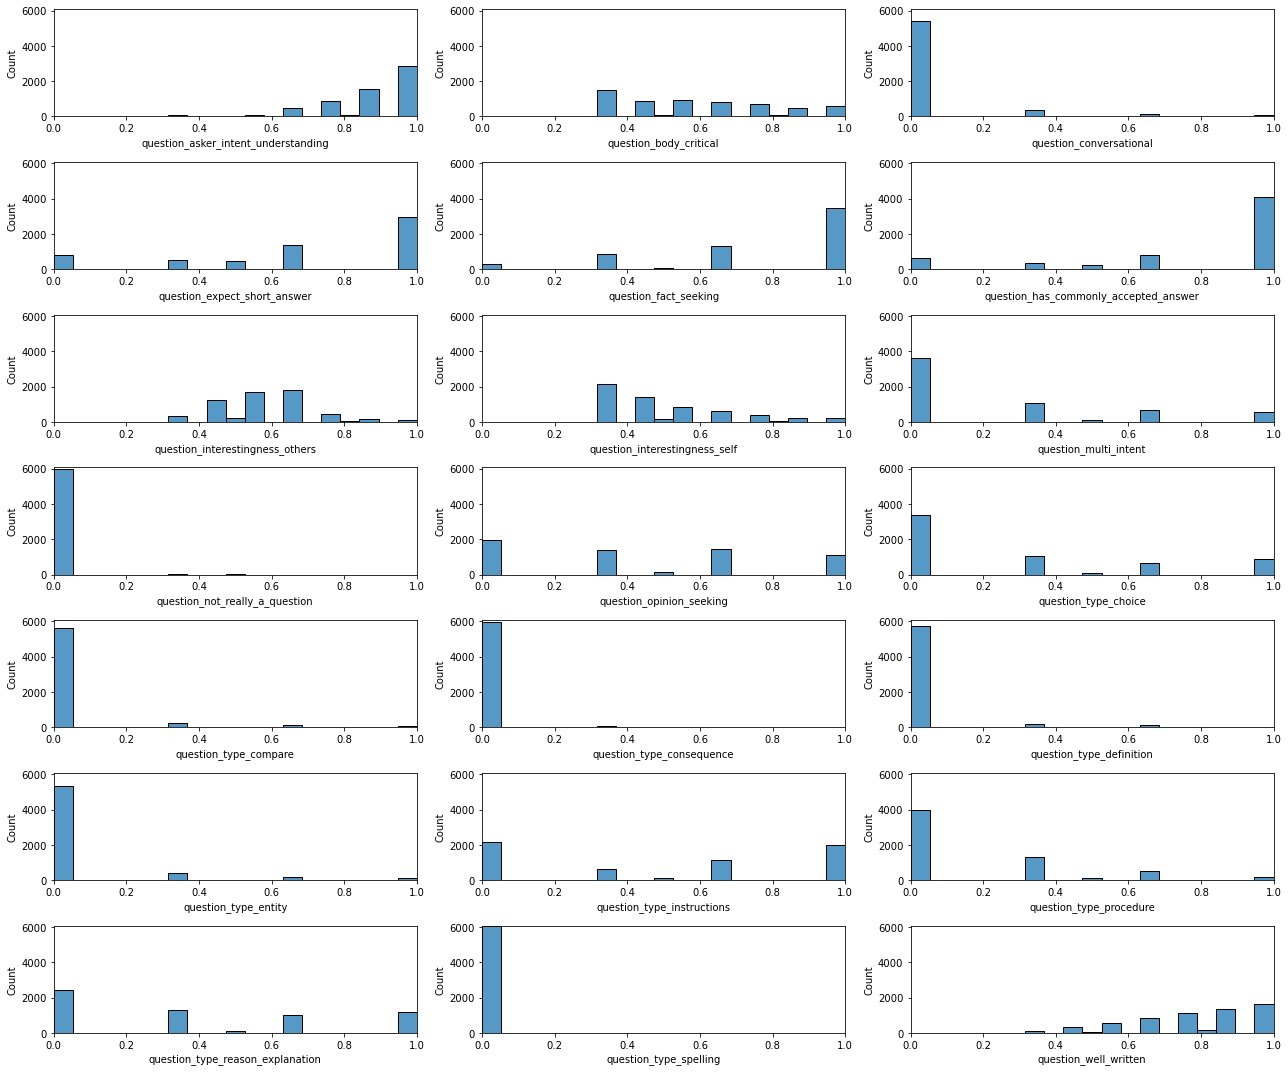

In [69]:
eda_class = eda()
eda_class.question_plot(y_question_df)

<a id="6.Multi-Tokenize"></a>
# 6.Multi-Tokenize
<a href="#2.Table of Contents">Click this Link back to Top</a>

There are seveal ways we can let model to learn how to provide score in each judgement

In [ ]:
1.TFIDF
2.Embedding
3.GLOVE
4.LDA

In [ ]:
1.CNN(u-gim, bi, trigum = contcant)
2.CNN 
3.GRU
4.BERT

In [ ]:
chatbot
BLUE Rougue

<a id="9.Main Function"></a>
# 9.Main Function
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [48]:
def main_function():
    """
    We use this function to call process one by one.
    """
    pre = preprocess_data()
    df_raw, X_question_df, X_answer_df, y_question_df, y_answer_df = pre.import_data()

    clean = clean_data()
    df_cleaned = clean.clean_data(X_question_df, column_1 ='question' )
    
    return df_raw, X_question_df, X_answer_df, y_question_df, y_answer_df, df_cleaned

In [49]:
if __name__=="__main__":
    df_raw, X_question_df, X_answer_df, y_question_df, y_answer_df, df_cleaned = main_function()

************************************************** Start Clean data **************************************************
**************************************** End clean_data() with 3.0568 second ****************************************



In [72]:
X_question_df.head(3)

,qa_id,question_title,question_body,category,host,question,cleaned
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,LIFE_ARTS,photo.stackexchange.com,What am I losing when using extension tubes in...,what am losing when using extension tubes inst...
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,CULTURE,rpg.stackexchange.com,What is the distinction between a city and a s...,what is the distinction between city and spraw...
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,SCIENCE,electronics.stackexchange.com,Maximum protusion length for through-hole comp...,maximum protusion length for throughhole compo...


In [73]:
y_question_df.head(5)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,...,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written
0,1.000000,0.333333,0.000000,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.000000
1,1.000000,1.000000,0.000000,0.5,1.0,1.0,0.444444,0.444444,0.666667,0.0,...,0.666667,0.666667,0.0,0.333333,0.0,0.0,0.000000,0.333333,0.0,0.888889
2,0.888889,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.444444,0.333333,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.333333,0.333333,0.0,0.777778
3,0.888889,0.666667,0.666667,1.0,1.0,1.0,0.444444,0.444444,0.000000,0.0,...,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.888889
4,1.000000,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.666667,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.000000,0.0,1.000000


<a id="10.Unused Code"></a>
# 10.Unused Cod
<a href="#1.Summary">Click this Link back to Top</a>

1.using question_user_page as benchmark, split quetsion_title or question_body into train_test, we believe different website have different type questions, so we can make evaluate and predict model

2.Using unsupervise learning to cluster question into differnt type, culster is depending on data preprocessing granularity. smaller grandularity, more spase cluster

3.After i embedding these sentence, you can use KNN SVM to do unsuperviese cluster

4.Using categore to cluster by CNN(n-gram / Glove / miniGPT）

5.Generage numerical value by former data and compart to anser_well_written

6.extract the root url like photo.stackchange.com to try to classfiy it with some argothrim, same question is to catgory column

7.If the result is not good enough, try to use url to grab more data to analysis

8.The data for this competition includes questions and answers from various StackExchange properties. Your task is to predict target values of 30 labels for each question-answer pair.

The list of 30 target labels are the same as the column names in the sample_submission.csv file. Target labels with the prefix question_ relate to the question_title and/or question_body features in the data. Target labels with the prefix answer_ relate to the answer feature.

9.for each dataframe maybe we need add category, and that will imporove performance

10.Stopword is meaningful for answer sequence, and so as punctuation. Try to only eliminate useless punctuatinon like '\`' but remain '?'and '!'
11.embedding is random initial word vector, but we can use Glove to import pretrain to impove performance

12.evalution part try to use BLEU score 

- https://www.tensorflow.org/tutorials/text/word_embeddings?hl=zh-cn
- https://towardsdatascience.com/nlp-building-a-question-answering-model-ed0529a68c54